In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from functools import partial

In [2]:
from neural_process_model_v2 import NeuralProcess
from gp_curves import GPCurvesGenerator, plot_func

In [3]:
TRAINING_ITERATIONS = int(1e4) # 1e5
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(1e4)

In [4]:
dataset_train = GPCurvesGenerator(batch_size=64, max_size=MAX_CONTEXT_POINTS)
dataset_test = GPCurvesGenerator(batch_size=1, max_size=MAX_CONTEXT_POINTS, testing=True)
data_train = dataset_train.generate()



def gen(dataset):
    data_train = dataset.generate()
    for i in range(TRAINING_ITERATIONS):
        context = tf.concat((data_train[0][0], data_train[0][1]), axis=1)
        query = data_train[1]
        target = data_train[2]
        yield ((context, query), target)

train_ds = tf.data.Dataset.from_generator(
            partial(gen, dataset_train),
            output_types=((tf.float32, tf.float32), tf.float32)
        )

test_ds = tf.data.Dataset.from_generator(
            partial(gen, dataset_test),
            output_types=((tf.float32, tf.float32), tf.float32)
        )

In [5]:
z_output_sizes = [128, 128, 128, 128]
enc_output_sizes = [128, 128, 128, 128]
dec_output_sizes = [128, 128, 1]

model = NeuralProcess(z_output_sizes, enc_output_sizes, dec_output_sizes)



#opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [6]:
# def loss(target_y, pred_y):
#     dist, _, _ = pred_y#self(context, query)
#     log_prob = dist.log_prob(target)
#     log_prob = tf.reduce_sum(log_prob)

#     prior, _, _ = self.z_prob(self.z_encoder(context))
#     posterior, _, _ = self.z_prob(self.z_encoder([query, target]))

#     kl = tfp.distributions.kl_divergence(prior, posterior)
#     kl = tf.reduce_sum(kl)

#     # maximize variational lower bound
#     loss = -log_prob + kl
#     return loss


def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    #dist,mu, sigma = pred_y
    # mu = pred_y[1]
    # sigma = pred_y[2]
    
    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    #dist = pred_y
    return -dist.log_prob(target_y)

model.compile(loss=loss, optimizer='adam')

In [7]:
model.fit(train_ds, epochs=1)

10000/10000 [==============================] - 365s 36ms/step - loss: -0.2156


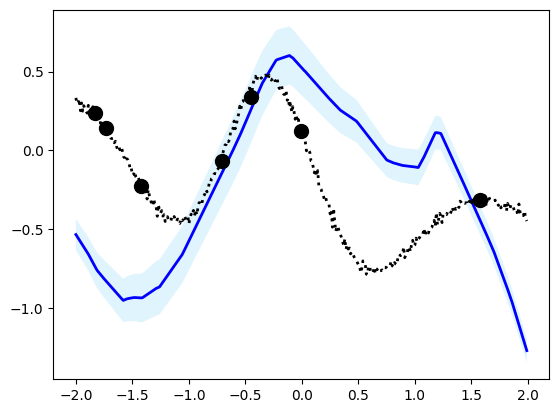

In [8]:
def plot():
    test_sample = next(gen(dataset_test))
    (context, query), target = test_sample
    pred_y = model(test_sample[0])
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    cx, cy = tf.split(context, num_or_size_splits=2, axis=1)
    plot_func(query, target, cx, cy, mu, sigma)
plot()